In [1]:
from pytube import YouTube
# misc
import os
import shutil
import math
import datetime
# plots
import matplotlib.pyplot as plt
# %matplotlib inline
# image operation
import cv2
from PIL import Image
import numpy as np
import timeit
import pafy

In [75]:
video = YouTube('https://youtu.be/tsdQyvJ99fA')
# video = YouTube('https://www.youtube.com/watch?v=NqC_1GuY3dw')

In [76]:
print(video.length)
print(video.rating)
print(video.views)

623
4.9245281
36939


In [19]:
video.streams.all()

<ipython-input-19-7805edc0d53f>:1: DeprecationWarning: Call to deprecated function all (This object can be treated as a list, all() is useless).
  video.streams.all()


[<Stream: itag="18" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.42001E" acodec="mp4a.40.2" progressive="True" type="video">,
 <Stream: itag="22" mime_type="video/mp4" res="720p" fps="30fps" vcodec="avc1.64001F" acodec="mp4a.40.2" progressive="True" type="video">,
 <Stream: itag="313" mime_type="video/webm" res="2160p" fps="30fps" vcodec="vp9" progressive="False" type="video">,
 <Stream: itag="271" mime_type="video/webm" res="1440p" fps="30fps" vcodec="vp9" progressive="False" type="video">,
 <Stream: itag="137" mime_type="video/mp4" res="1080p" fps="30fps" vcodec="avc1.64001f" progressive="False" type="video">,
 <Stream: itag="248" mime_type="video/webm" res="1080p" fps="30fps" vcodec="vp9" progressive="False" type="video">,
 <Stream: itag="136" mime_type="video/mp4" res="720p" fps="30fps" vcodec="avc1.4d4016" progressive="False" type="video">,
 <Stream: itag="247" mime_type="video/webm" res="720p" fps="30fps" vcodec="vp9" progressive="False" type="video">,
 <Stream: itag

In [62]:
video.streams.filter(file_extension = "mp4").all()

<ipython-input-62-4971d2dde35d>:1: DeprecationWarning: Call to deprecated function all (This object can be treated as a list, all() is useless).
  video.streams.filter(file_extension = "mp4").all()


[<Stream: itag="18" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.42001E" acodec="mp4a.40.2" progressive="True" type="video">,
 <Stream: itag="22" mime_type="video/mp4" res="720p" fps="30fps" vcodec="avc1.64001F" acodec="mp4a.40.2" progressive="True" type="video">,
 <Stream: itag="137" mime_type="video/mp4" res="1080p" fps="30fps" vcodec="avc1.64001f" progressive="False" type="video">,
 <Stream: itag="136" mime_type="video/mp4" res="720p" fps="30fps" vcodec="avc1.4d4016" progressive="False" type="video">,
 <Stream: itag="135" mime_type="video/mp4" res="480p" fps="30fps" vcodec="avc1.4d4015" progressive="False" type="video">,
 <Stream: itag="134" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.4d400c" progressive="False" type="video">,
 <Stream: itag="133" mime_type="video/mp4" res="240p" fps="30fps" vcodec="avc1.4d400b" progressive="False" type="video">,
 <Stream: itag="160" mime_type="video/mp4" res="144p" fps="30fps" vcodec="avc1.4d400a" progressive="False" type

In [66]:
video.streams.get_by_itag(137).download(output_path='/home/arunkumarr2346/downloads/')

'/home/arunkumarr2346/downloads/Battle Frenzy Chapter 311 English.mp4'

In [170]:
class FrameExtractor():
    '''
    Class used for extracting frames from a video file.
    '''
    def __init__(self, video_path):
        self.video_path = video_path
        self.vid_cap = cv2.VideoCapture(video_path)
        self.n_frames = int(self.vid_cap.get(cv2.CAP_PROP_FRAME_COUNT))
        self.fps = int(self.vid_cap.get(cv2.CAP_PROP_FPS))
        
    def get_video_duration(self):
        duration = self.n_frames/self.fps
        print(f'Duration: {datetime.timedelta(seconds=duration)}')
        
    def get_n_images(self, every_x_frame):
        n_images = math.floor(self.n_frames / every_x_frame) + 1
        print(f'Extracting every {every_x_frame} (nd/rd/th) frame would result in {n_images} images.')
    def img_comp(self,image1,image2):
        cv2_image1_cnvtd = cv2.cvtColor(image1,cv2.COLOR_BGR2RGB)
        cv2_image2_cnvtd = cv2.cvtColor(image2,cv2.COLOR_BGR2RGB)
        i1 = Image.fromarray(cv2_image1_cnvtd)
        i2 = Image.fromarray(cv2_image2_cnvtd)
        assert i1.mode == i2.mode, "Different kinds of images."
        assert i1.size == i2.size, "Different sizes."
        
        pairs = zip(i1.getdata(), i2.getdata())
        if len(i1.getbands()) == 1:
            # for gray-scale jpegs
            dif = sum(abs(p1-p2) for p1,p2 in pairs)
        else:
            dif = sum(abs(c1-c2) for p1,p2 in pairs for c1,c2 in zip(p1,p2))
        
        ncomponents = i1.size[0] * i1.size[1] * 3
        diff_per = (dif / 255.0 * 100) / ncomponents
        return diff_per

    def extract_distinct_frames(self, img_name, dest_path=None, img_ext = '.jpg'):
        if not self.vid_cap.isOpened():
            self.vid_cap = cv2.VideoCapture(self.video_path)
        
        if dest_path is None:
            dest_path = os.getcwd()
        else:
            if not os.path.isdir(dest_path):
                os.mkdir(dest_path)
                print(f'Created the following directory: {dest_path}')
        
        frame_cnt = 0
        img_cnt = 0
        success,curr_image = self.vid_cap.read() 
        prev_image = curr_image

        while self.vid_cap.isOpened():
            
            
            if not success:
                break
            
            # diff_image = cv2.subtract(prev_image,curr_image)
            diff_image = cv2.absdiff(prev_image,curr_image)
            std_diff_image = np.std(diff_image)
            # image_diff = float(self.img_comp(prev_image,curr_image))
            # print(curr_image.data,os.path.join(dest_path, ''.join([img_name, '_', str(frame_cnt), img_ext])),image_diff)
            # img_path = os.path.join(dest_path, ''.join([img_name, '_', str(frame_cnt), img_ext]))
            # cv2.imwrite(img_path, curr_image) 

            if std_diff_image > 10:
                img_path = os.path.join(dest_path, ''.join([img_name, '_', str(img_cnt), img_ext]))
                cv2.imwrite(img_path, curr_image)  
                # prev_image = curr_image
                img_cnt += 1
            
            frame_cnt += 1
            prev_image = curr_image
            success,curr_image = self.vid_cap.read() 

        
        self.vid_cap.release()
        cv2.destroyAllWindows()
    def extract_frames(self, every_x_frame, img_name, dest_path=None, img_ext = '.jpg'):
        if not self.vid_cap.isOpened():
            self.vid_cap = cv2.VideoCapture(self.video_path)
        
        if dest_path is None:
            dest_path = os.getcwd()
        else:
            if not os.path.isdir(dest_path):
                os.mkdir(dest_path)
                print(f'Created the following directory: {dest_path}')
        
        frame_cnt = 0
        img_cnt = 0

        while self.vid_cap.isOpened():
            
            success,image = self.vid_cap.read() 
            
            if not success:
                break
            
            if frame_cnt % every_x_frame == 0:
                img_path = os.path.join(dest_path, ''.join([img_name, '_', str(img_cnt), img_ext]))
                cv2.imwrite(img_path, image)  
                img_cnt += 1
                
            frame_cnt += 1
        
        self.vid_cap.release()
        cv2.destroyAllWindows()

In [171]:
fe = FrameExtractor('Battle Frenzy Chapter 311 English.mp4')

In [172]:
fe.extract_distinct_frames(img_name='BattleFrenzyChapter311', 
                  dest_path='BattleFrenzyChapter311D')

Created the following directory: BattleFrenzyChapter311D


In [14]:
fe1.extract_frames(every_x_frame=500, 
                  img_ext = '.png',
                  img_name='BattleFrenzyChapter311', 
                  dest_path='BattleFrenzyChapter311A')

Created the following directory: BattleFrenzyChapter311A


In [12]:
prev_image = cv2.imread('BattleFrenzyChapter311A/BattleFrenzyChapter311_2.png')
curr_image = cv2.imread('BattleFrenzyChapter311A/BattleFrenzyChapter311_3.png')
next_image = cv2.imread('BattleFrenzyChapter311A/BattleFrenzyChapter311_4.png')


In [68]:
%%time
# absdiff1 = cv2.absdiff(prev_image, curr_image)
# absdiff2 = cv2.absdiff(curr_image, next_image)

print(np.std(absdiff1))
print(np.std(absdiff2))


1.1729003117570662
55.01259091271418
CPU times: user 62 ms, sys: 8.94 ms, total: 70.9 ms
Wall time: 78.7 ms


In [69]:
%%time
# diff1 = cv2.subtract(prev_image,curr_image)
# diff2 = cv2.subtract(curr_image,next_image)

print(np.std(diff1))
print(np.std(diff2))


0.900655569553435
47.76258752015136
CPU times: user 45.2 ms, sys: 170 µs, total: 45.4 ms
Wall time: 41.2 ms


In [23]:
%%time

compare1 = cv2.compare(prev_image,curr_image,0)
compare2 = cv2.compare(curr_image,next_image,0)

print(np.std(compare1))
print(np.std(compare2))

122.21528310249417
122.740053935507
CPU times: user 43.1 ms, sys: 1.08 ms, total: 44.2 ms
Wall time: 37.9 ms


In [62]:
%%time
prev_image_bw = cv2.cvtColor(prev_image, cv2.COLOR_BGR2GRAY)
curr_image_bw  = cv2.cvtColor(curr_image, cv2.COLOR_BGR2GRAY)
next_image_bw  = cv2.cvtColor(next_image, cv2.COLOR_BGR2GRAY)

CPU times: user 0 ns, sys: 9.53 ms, total: 9.53 ms
Wall time: 3.04 ms


In [66]:
%%time
absdiff1_bw = cv2.absdiff(prev_image_bw, curr_image_bw)
absdiff2_bw = cv2.absdiff(curr_image_bw, next_image_bw)

# print(np.std(absdiff1_bw))
# print(np.std(absdiff2_bw))


CPU times: user 2.67 ms, sys: 1.21 ms, total: 3.88 ms
Wall time: 1.63 ms


In [67]:
%%time
# diff1_bw = cv2.subtract(prev_image_bw, curr_image_bw)
# diff2_bw = cv2.subtract(curr_image_bw, next_image_bw)

print(np.std(diff1_bw))
print(np.std(diff2_bw))


0.6600269121256898
45.68649906840018
CPU times: user 13.8 ms, sys: 1.21 ms, total: 15 ms
Wall time: 12 ms


In [47]:
print(curr_image.data)

In [162]:
compare1 = cv2.compare(prev_image,curr_image,0)
compare2 = cv2.compare(curr_image,next_image,0)

print(np.std(compare1))
print(np.std(compare2))

122.21528310249417
122.740053935507


In [88]:
sum(compare)

array([[200, 200, 200],
       [200, 200, 200],
       [200, 200, 200],
       ...,
       [202, 202, 202],
       [200, 200, 200],
       [200, 200, 200]], dtype=uint8)

In [134]:
diff1 = cv2.subtract(prev_image,curr_image)
diff2 = cv2.subtract(curr_image,next_image)

In [161]:
b, g, r = cv2.split(diff1)

print(cv2.countNonZero(b))
print(cv2.countNonZero(g))
print(cv2.countNonZero(r))

print((cv2.countNonZero(b)* 100)/ diff1.size)
print((cv2.countNonZero(g)* 100)/ diff1.size)
print((cv2.countNonZero(r)* 100)/ diff1.size)

print(np.std(b))
print(np.std(g))
print(np.std(r))
print(np.std(diff1))


121504
111151
119803
6.167966211825861
5.6424118745938925
6.081617527615335
1.0246740044419163
0.7333108798117731
0.915285815650784
0.900655569553435


In [160]:
b, g, r = cv2.split(diff2)

print(cv2.countNonZero(b))
print(cv2.countNonZero(g))
print(cv2.countNonZero(r))

print(np.shape(b))
print(np.shape(g))
print(np.shape(r))


print((cv2.countNonZero(b)* 100)/ diff2.size)
print((cv2.countNonZero(g)* 100)/ diff2.size)
print((cv2.countNonZero(r)* 100)/ diff2.size)


print(np.std(b))
print(np.std(g))
print(np.std(r))
print(np.std(diff2))


239587
229298
231462
(1080, 608)
(1080, 608)
(1080, 608)
12.16227054905783
11.639965074723847
11.74981725146199
46.24404736794454
46.990388730025046
49.90475596482395
47.76258752015136


In [38]:
from PIL import Image
cv2_cnvt_curr = cv2.cvtColor(curr_image,cv2.COLOR_BGR2RGB)
cv2_cnvt_prev = cv2.cvtColor(prev_image,cv2.COLOR_BGR2RGB)
i1 = Image.fromarray(cv2_cnvt_curr)
i2 = Image.fromarray(cv2_cnvt_prev)
# i1 = Image.open("BattleFrenzyChapter311A/BattleFrenzyChapter311_2.png")
# i2 = Image.open("BattleFrenzyChapter311A/BattleFrenzyChapter311_3.png")
assert i1.mode == i2.mode, "Different kinds of images."
assert i1.size == i2.size, "Different sizes."
 
pairs = zip(i1.getdata(), i2.getdata())
if len(i1.getbands()) == 1:
    # for gray-scale jpegs
    dif = sum(abs(p1-p2) for p1,p2 in pairs)
else:
    dif = sum(abs(c1-c2) for p1,p2 in pairs for c1,c2 in zip(p1,p2))
 
ncomponents = i1.size[0] * i1.size[1] * 3
print ("Difference (percentage):", (dif / 255.0 * 100) / ncomponents)

Difference (percentage): 0.2729534552612468


In [156]:
# img1 = cv2.imread('dog.jpg', 0)
# img2 = cv2.imread('cat.jpg', 0)

#--- take the absolute difference of the images ---
res = cv2.absdiff(curr_image, prev_image)

# res = cv2.absdiff(next_image, curr_image)

# avg_image = np.mean(np.array(curr_image),np.array(prev_image))

avg_image = (np.array(curr_image) + np.array(prev_image)) / 2.0 
# avg_image = np.mean(np.array([ curr_image, prev_image ]), axis=0 )
# print(avg_image)

#--- convert the result to integer type ---
res = res.astype(np.uint8)

#--- find percentage difference based on number of pixels that are not zero ---
print(np.count_nonzero(res))
print(res.size)
print(np.std(res))
percentage = (np.count_nonzero(res) * 100)/ res.size
print(percentage)
print(res.sum())
print(curr_image.sum())
print(sum(sum(res))/sum(sum(curr_image)))
# percentage1 = np.average((res * 100) +1)/ (curr_image + 1)

res_b, res_g, res_r = cv2.split(res)
curr_image_b, curr_image_g, curr_image_r = cv2.split(curr_image)
percentage1 = np.average((res_b * 100) +255)/ (curr_image_b +255)
# print(sum(res_b))
# print(sum(curr_image_b))
# np.sum
# print(percentage1)
# FilePath = '/home/arunkumarr2346/downloads/percentage1.csv'

# for lines in percentage1:
#     for line in lines:
#         print(line)
# with open(FilePath,'w') as f:
#     for line in percentage1:
#         f.write(line)


704325
1969920
1.1729003117570662
35.75399000974659
1371126
319815949
[9.9375     1.11111111 0.17788462]


In [95]:
b, g, r = cv2.split(res)

print(cv2.countNonZero(b))
print(cv2.countNonZero(g))
print(cv2.countNonZero(r))

242715
223931
237679


In [94]:
sum(sum(res))

array([159,  50,  37], dtype=uint8)

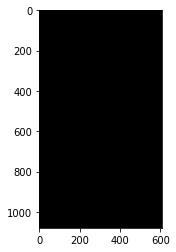

In [127]:
plt.imshow(diff1)

In [23]:
diff_image = curr_image - prev_image

In [13]:
cv2.imwrite('/home/arunkumarr2346/downloads/BattleFrenzyChapter311-diffB.png',diff1)

True

In [ ]:
cv2.imshow('image1', diff_image)

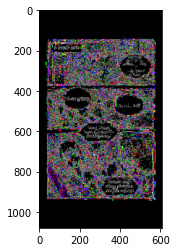

In [24]:
plt.imshow(diff_image)

In [14]:
import pafy

videoUrl = 'https://youtu.be/tsdQyvJ99fA'

video = pafy.new(videoUrl)
best = video.getbest(preftype='mp4')

best.url




/home/arunkumarr2346/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'https://r2---sn-ci5gup-h55l.googlevideo.com/videoplayback?expire=1609268905&ei=SSrrX4WeDpWK3LUPqu-a2Aw&ip=106.208.143.86&id=o-AO4NkvJa2BESeM_zNZow9nAvpjdV-s4Ki0-6r5NkmZH0&itag=22&source=youtube&requiressl=yes&mh=3L&mm=31%2C26&mn=sn-ci5gup-h55l%2Csn-npoeeney&ms=au%2Conr&mv=m&mvi=2&pcm2cms=yes&pl=24&initcwndbps=232500&vprv=1&mime=video%2Fmp4&ns=d4SCO2iYi-3y5RWC2ZkFJhEF&ratebypass=yes&dur=622.782&lmt=1580512987155417&mt=1609247090&fvip=2&c=WEB&txp=5432432&n=GQ4ykjBd6ERO1Tn5&sparams=expire%2Cei%2Cip%2Cid%2Citag%2Csource%2Crequiressl%2Cvprv%2Cmime%2Cns%2Cratebypass%2Cdur%2Clmt&sig=AOq0QJ8wRQIhAPErAKRzEbFHlDfEUaseS0j4XzApOK1aiQjkzuhJUKgSAiBw9AZnG5g0rW9jekEGmIGdnjUmuccSIls1wsWNbCGZfw%3D%3D&lsparams=mh%2Cmm%2Cmn%2Cms%2Cmv%2Cmvi%2Cpcm2cms%2Cpl%2Cinitcwndbps&lsig=AG3C_xAwRQIgVV4tQiLe1OiI9i74sUYVMmSb3nvkFqn9-LPOkZb7fE4CIQDnDgBB2Gqauk5P-OTwa0pCJgiEuCEY4XJTdDXpB0ibEg%3D%3D'

In [4]:
video.

[normal:mp4@202x360, normal:mp4@406x720]

In [18]:
from pytube import YouTube

video1 = YouTube('https://youtu.be/tsdQyvJ99fA')

# video.streams.all()
video1.streams.filter(file_extension = "mp4").all()
# video1.streams.get_by_itag(22).url
# video.streams.get_by_itag(22).download(output_path='/home/arunkumarr2346/downloads/')

/home/arunkumarr2346/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-18-0f2ca053b86a>:6: DeprecationWarning: Call to deprecated function all (This object can be treated as a list, all() is useless).
  video1.streams.filter(file_extension = "mp4").all()


[<Stream: itag="18" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.42001E" acodec="mp4a.40.2" progressive="True" type="video">,
 <Stream: itag="22" mime_type="video/mp4" res="720p" fps="30fps" vcodec="avc1.64001F" acodec="mp4a.40.2" progressive="True" type="video">,
 <Stream: itag="137" mime_type="video/mp4" res="1080p" fps="30fps" vcodec="avc1.64001f" progressive="False" type="video">,
 <Stream: itag="136" mime_type="video/mp4" res="720p" fps="30fps" vcodec="avc1.4d4016" progressive="False" type="video">,
 <Stream: itag="135" mime_type="video/mp4" res="480p" fps="30fps" vcodec="avc1.4d4015" progressive="False" type="video">,
 <Stream: itag="134" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.4d400c" progressive="False" type="video">,
 <Stream: itag="133" mime_type="video/mp4" res="240p" fps="30fps" vcodec="avc1.4d400b" progressive="False" type="video">,
 <Stream: itag="160" mime_type="video/mp4" res="144p" fps="30fps" vcodec="avc1.4d400a" progressive="False" type

In [15]:
import cv2
video.streams.get_by_itag(22).url

AttributeError: 'list' object has no attribute 'get_by_itag'

In [5]:
import cv2
from pytube import YouTube

videoUrl = 'https://www.youtube.com/watch?v=bMXSG83nhdA&list=PLgdSLmf4viPfzkC5LsChx-5p1tjQh_IZd&index=2'

video = YouTube(videoUrl)
dataUrl = video.streams.get_by_itag(137).url
compUrl = video.streams.get_by_itag(160).url

In [8]:
video.streams.all()

<ipython-input-8-7805edc0d53f>:1: DeprecationWarning: Call to deprecated function all (This object can be treated as a list, all() is useless).
  video.streams.all()


[<Stream: itag="18" mime_type="video/mp4" res="360p" fps="30fps" vcodec="avc1.42001E" acodec="mp4a.40.2" progressive="True" type="video">,
 <Stream: itag="22" mime_type="video/mp4" res="720p" fps="30fps" vcodec="avc1.64001F" acodec="mp4a.40.2" progressive="True" type="video">,
 <Stream: itag="137" mime_type="video/mp4" res="1080p" fps="30fps" vcodec="avc1.640028" progressive="False" type="video">,
 <Stream: itag="248" mime_type="video/webm" res="1080p" fps="30fps" vcodec="vp9" progressive="False" type="video">,
 <Stream: itag="136" mime_type="video/mp4" res="720p" fps="30fps" vcodec="avc1.4d401f" progressive="False" type="video">,
 <Stream: itag="247" mime_type="video/webm" res="720p" fps="30fps" vcodec="vp9" progressive="False" type="video">,
 <Stream: itag="135" mime_type="video/mp4" res="480p" fps="30fps" vcodec="avc1.4d401e" progressive="False" type="video">,
 <Stream: itag="244" mime_type="video/webm" res="480p" fps="30fps" vcodec="vp9" progressive="False" type="video">,
 <Stream:

In [11]:
video.streams.get_by_itag(136).download(output_path='/home/arunkumarr2346/downloads/')

'/home/arunkumarr2346/downloads/Battle Frenzy Chapter 313 English.mp4'

In [4]:
# misc
import os
import shutil
import math
import datetime
import numpy as np

# image operation
import cv2
from PIL import Image
import img2pdf
# import pillow

class FrameExtractor():
    '''
    Class used for extracting frames from a video file.
    '''
    def __init__(self, video_path_comp,video_path_data):
        self.video_path_comp = video_path_comp
        self.vid_cap_comp = cv2.VideoCapture(video_path_comp)
        self.video_path_data = video_path_data
        self.vid_cap_data = cv2.VideoCapture(video_path_data)
        self.n_frames = int(self.vid_cap_data.get(cv2.CAP_PROP_FRAME_COUNT))
        self.fps = int(self.vid_cap_data.get(cv2.CAP_PROP_FPS))
        
    def get_video_duration(self):
        duration = self.n_frames/self.fps
        print(f'Duration: {datetime.timedelta(seconds=duration)}')
        
    def get_n_images(self, every_x_frame):
        n_images = math.floor(self.n_frames / every_x_frame) + 1
        print(f'Extracting every {every_x_frame} (nd/rd/th) frame would result in {n_images} images.')

    def img_comp(self,image1,image2):
        cv2_image1_cnvtd = cv2.cvtColor(image1,cv2.COLOR_BGR2RGB)
        cv2_image2_cnvtd = cv2.cvtColor(image2,cv2.COLOR_BGR2RGB)
        i1 = Image.fromarray(cv2_image1_cnvtd)
        i2 = Image.fromarray(cv2_image2_cnvtd)
        assert i1.mode == i2.mode, "Different kinds of images."
        assert i1.size == i2.size, "Different sizes."
        
        pairs = zip(i1.getdata(), i2.getdata())
        if len(i1.getbands()) == 1:
            # for gray-scale jpegs
            dif = sum(abs(p1-p2) for p1,p2 in pairs)
        else:
            dif = sum(abs(c1-c2) for p1,p2 in pairs for c1,c2 in zip(p1,p2))
        
        ncomponents = i1.size[0] * i1.size[1] * 3
        diff_per = (dif / 255.0 * 100) / ncomponents
        return diff_per

    def output_file(self,image_list,file_name,download_path,file_ext='.pdf'):
        if file_ext == '.pdf': 
            new_image_list = []
            pdf_path  = f'{download_path}/{file_name}{file_ext}'
            for image in image_list:
                cv2_image_cnvtd = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
                pil_image = Image.fromarray(cv2_image_cnvtd)
                new_image_list.append(pil_image)
            # converting into chunks using img2pdf 
            new_image_list[0].save(pdf_path, save_all = True, quality=100, append_images = new_image_list[1:])
            # with open(pdf_path,"wb") as f:
	        #     f.write(img2pdf.convert(new_image_list))
        else:
            img_cnt=0
            for image in image_list:
                img_path = os.path.join(download_path,file_name, ''.join([file_name, '_', str(img_cnt), file_ext]))
                cv2.imwrite(img_path, image)
                img_cnt += 1


    def extract_distinct_frames(self, every_x_frame, file_name, dest_path, file_ext = '.pdf', tolerance=5):
        if not self.vid_cap_comp.isOpened():
            self.vid_cap_comp = cv2.VideoCapture(self.video_path_comp)
        
        if dest_path is None:
            dest_path = os.getcwd()
        else:
            if not os.path.isdir(dest_path):
                os.mkdir(dest_path)
                print(f'Created the following directory: {dest_path}')
        
        image_list = []
        frame_cnt = 0
        img_cnt = 0

        success_comp,curr_image_comp = self.vid_cap_comp.read() 
        # prev_image_comp = curr_image_comp
        curr_image_comp_bw = cv2.cvtColor(curr_image_comp,cv2.COLOR_BGR2GRAY)
        prev_image_comp_bw = curr_image_comp_bw

        success_data,curr_image_data = self.vid_cap_data.read() 

        while self.vid_cap_comp.isOpened():
            
            if not success_comp:
                break
            
            if not success_data:
                break

            if frame_cnt % every_x_frame == 0:
                curr_image_comp_bw = cv2.cvtColor(curr_image_comp,cv2.COLOR_BGR2GRAY)
                # diff_image_bw = cv2.subtract(prev_image_comp_bw,curr_image_comp_bw)
                diff_image_bw = cv2.absdiff(prev_image_comp_bw,curr_image_comp_bw)
                std_diff_image = np.std(diff_image_bw)

                if std_diff_image > tolerance:
                    image_list.append(curr_image_data)
            
                # prev_image_comp = curr_image_comp
                success_comp,curr_image_comp = self.vid_cap_comp.read() 
                success_data,curr_image_data = self.vid_cap_data.read() 
                prev_image_comp_bw = curr_image_comp_bw

            frame_cnt += 1

        self.output_file(image_list,file_name,dest_path,file_ext)

        self.vid_cap_comp.release()
        cv2.destroyAllWindows()
    def extract_frames(self, every_x_frame, file_name, dest_path=None, file_ext = '.jpg'):
        if not self.vid_cap_comp.isOpened():
            self.vid_cap_comp = cv2.VideoCapture(self.video_path_comp)
        
        if dest_path is None:
            dest_path = os.getcwd()
        else:
            if not os.path.isdir(dest_path):
                os.mkdir(dest_path)
                print(f'Created the following directory: {dest_path}')
        
        frame_cnt = 0
        img_cnt = 0

        while self.vid_cap_comp.isOpened():
            
            success,image = self.vid_cap_comp.read() 
            
            if not success:
                break
            
            if frame_cnt % every_x_frame == 0:
                img_path = os.path.join(dest_path, ''.join([file_name, '_', str(img_cnt), file_ext]))
                cv2.imwrite(img_path, image)  
                img_cnt += 1
                
            frame_cnt += 1
        
        self.vid_cap_comp.release()
        cv2.destroyAllWindows()

In [5]:
%%time

fe = FrameExtractor(compUrl,dataUrl)
image_list = fe.extract_distinct_frames(every_x_frame=300,
                                        file_name=video.title, 
                                        dest_path=video.author,
                                        tolerance=10
                                        )

In [91]:
video.author

'LoNE WoLvES'

In [95]:
file_name = video.title
download_path = video.author
img_cnt = 0
file_ext = '.pdf'
os.path.join(download_path, ''.join([file_name, '_', str(img_cnt), file_ext]))

'LoNE WoLvES/Battle Frenzy Chapter 311 English_0.pdf'

In [99]:
pdf_path  = f'{download_path}/{file_name}{file_ext}'
pdf_path

'LoNE WoLvES/Battle Frenzy Chapter 311 English.pdf'

In [214]:
from pytube import Playlist 
import pafy
# pl = Playlist('https://www.youtube.com/watch?v=-MVPypqXI5M&list=PLgdSLmf4viPfzkC5LsChx-5p1tjQh_IZd')
videoPlaylistUrl = 'https://www.youtube.com/playlist?list=PLgdSLmf4viPfzkC5LsChx-5p1tjQh_IZd'
videoUrl = 'https://www.youtube.com/watch?v=aqfTwdy-VSQ&list=PLgdSLmf4viPfzkC5LsChx-5p1tjQh_IZd&index=24'
playlist = pafy.get_playlist(videoPlaylistUrl)

video = YouTube(videoUrl) #'aqfTwdy-VSQ'
# video = YouTube('https://www.youtube.com/watch?v=qUrVk6i1x9E&list=PLgdSLmf4viPfzkC5LsChx-5p1tjQh_IZd&index=25') #'qUrVk6i1x9E'
# pl.videos

videoUrl1 = f"https://www.youtube.com/watch?v={playlist['items'][23]['playlist_meta']['encrypted_id']}&list={videoPlaylistUrl[38:]}&index={24}"

# i,playlist['items'][i-1]['playlist_meta']['title'],playlist['items'][i-1]['playlist_meta']['encrypted_id']
# video.streams.get_by_itag(137).url
print(videoUrl)
print(videoPlaylistUrl[40:(len(videoPlaylistUrl)-39)])
print(videoUrl==videoUrl1)

https://www.youtube.com/watch?v=aqfTwdy-VSQ&list=PLgdSLmf4viPfzkC5LsChx-5p1tjQh_IZd&index=24

True


In [213]:
videoUrl = f"https://www.youtube.com/watch?v={playlist['items'][23]['playlist_meta']['encrypted_id']}&list={videoPlaylistUrl[38:]}&index={24}"
print(videoUrl)

https://www.youtube.com/watch?v=aqfTwdy-VSQ&list=PLgdSLmf4viPfzkC5LsChx-5p1tjQh_IZd&index=24


In [165]:
import pafy

videoPlaylistUrl = 'https://www.youtube.com/playlist?list=PLgdSLmf4viPfzkC5LsChx-5p1tjQh_IZd'



playlist = pafy.get_playlist(videoPlaylistUrl)
# playlist2 = pafy.get_playlist2(videoPlaylistUrl)





In [158]:
print(len(playlist['items']))

32


In [215]:
playlist['items'][24]['playlist_meta']['author']

'LoNE WoLvES'

In [217]:
playlist.get('items')[24].get('playlist_meta').get('author')

'LoNE WoLvES'

In [196]:
for i in range(1,len(playlist['items'])+1):
    # print(i,playlist['items'][i]['pafy'])
    print(i,playlist['items'][i-1]['playlist_meta']['title'],playlist['items'][i-1]['playlist_meta']['encrypted_id'])

1 Battle Frenzy Chapter 312 English -MVPypqXI5M
2 Battle Frenzy Chapter 313 English bMXSG83nhdA
3 Battle Frenzy Chapter 314 English RtwPwv33UfI
4 Battle Frenzy Chapter 315 English iBik0RM8oJk
5 Battle Frenzy Chapter 316 English ovkh4ay1BQQ
6 Battle Frenzy Chapter 317 English DJtxS33rhSU
7 Battle Frenzy Chapter 318 English XakYYlvMXGE
8 Battle Frenzy Chapter 319 English m5P27xALY0o
9 Battle Frenzy Chapter 320 English iYcUTy6HNfI
10 Battle Frenzy Chapter 321 English ovglcF-d_oM
11 Battle Frenzy Chapter 322 English Sal9j4SH7ns
12 Battle Frenzy Chapter 323 English hkWnDI14e4s
13 Battle Frenzy Chapter 324 English LMs8b7ktJVk
14 Battle Frenzy Chapter 325 English fw2YqxfZ1dg
15 Battle Frenzy Chapter 326 English q1guktpD6dU
16 Battle Frenzy Chapter 327 English En_EOSsTqO4
17 Battle Frenzy Chapter 328 English lQhZwYGcCXQ
18 Battle Frenzy Chapter 329 English ysAT69DXkK4
19 Battle Frenzy Chapter 330 English fWFXU4VwGdQ
20 Battle Frenzy Chapter 331 English 80yxbkpZD7U
21 Battle Frenzy Chapter 332 

In [3]:
def ConvertVideoToManga(UrlList):
    for videoUrl in UrlList:
        video = YouTube(videoUrl)
        dataUrl = video.streams.get_by_itag(137).url
        compUrl = video.streams.get_by_itag(160).url
        fe = FrameExtractor(compUrl,dataUrl)
        fe.extract_distinct_frames(every_x_frame=300,
                            file_name=video.title, 
                            dest_path=video.author,
                            tolerance=10
        )
        print(f'Processing completed for : {video.title}')


def ConvertVideoUrlToUrlList(Url,UrlType):
    UrlList=[]
    if UrlType.lower() == 'playlist':
        videoPlaylistUrl = Url
        playlist = pafy.get_playlist(videoPlaylistUrl)
        for i in range(1,len(playlist['items'])+1):
            videoUrl = f"https://www.youtube.com/watch?v={playlist['items'][i-1]['playlist_meta']['encrypted_id']}&list={videoPlaylistUrl[38:]}&index={i}"
            UrlList.append(videoUrl)
    elif UrlType.lower() == 'video':
        UrlList.append(Url)
    else:
        assert 'Invalid Url type'
    # print(UrlList)
    return UrlList

In [34]:
%%time

videoPlaylistUrl = 'https://www.youtube.com/playlist?list=PLgdSLmf4viPfzkC5LsChx-5p1tjQh_IZd'

videoUrllist = ConvertVideoUrlToUrlList(Url=videoPlaylistUrl,
                    UrlType='playlist'
                    )
download_path='/home/arunkumarr2346/downloads/'




CPU times: user 11.3 ms, sys: 0 ns, total: 11.3 ms
Wall time: 1.05 s


In [18]:
%%time

cnt = 0
for videoUrl in videoUrllist:
    video = YouTube(videoUrl)
    checkFile = f'{download_path}{video.title}.mp4'
    if os.path.isfile(checkFile):
        pass
    else:
        print(f'download started for : {video.title}')
        video.streams.get_by_itag(136).download(output_path=download_path)
        videoUrllist.remove(videoUrl)
        cnt+=1
    print(f'download completed for : {video.title}')
    if cnt==3:
        break

download started for : Battle Frenzy Chapter 325 English


KeyboardInterrupt: 

In [36]:
videoUrllist

['https://www.youtube.com/watch?v=jpdjxxog3NI&list=PLgdSLmf4viPfzkC5LsChx-5p1tjQh_IZd&index=1',
 'https://www.youtube.com/watch?v=w0ojarLOAr8&list=PLgdSLmf4viPfzkC5LsChx-5p1tjQh_IZd&index=2',
 'https://www.youtube.com/watch?v=FF7IuC6344k&list=PLgdSLmf4viPfzkC5LsChx-5p1tjQh_IZd&index=3',
 'https://www.youtube.com/watch?v=LDaxr1KdiFA&list=PLgdSLmf4viPfzkC5LsChx-5p1tjQh_IZd&index=4']

In [21]:
# import progressbar
def progress_Check(stream=None, chunk=10000, remaining=None):
    # print(file_size,remaining)
    # file_downloaded = file_size - remaining
    percentage = int(100-((remaining*100)/file_size))
    if percentage not in progress_set:
        print(percentage)
        progress_set.add(percentage)
    # percent = file_size - bytes_remaining + 1000000   
    # bar = progressbar.ProgressBar(max_value=file_size,  
    #                       widgets=widgets).start() 
    # try: 
    #     # updates the progress bar                                   
    #     bar.update(round(percent/1000000,2))
    # except: 
    #     # progress bar dont reach 100% so a little trick to make it 100    
    #     bar.update(round(file_size/1000000,2))

In [8]:
videoUrl = 'https://youtu.be/wnHW6o8WMas'

In [26]:
video = YouTube(videoUrl, on_progress_callback=progress_Check)
final_download_path = '/mnt/c/Users/Arun Kumar R/Downloads/youtubevideos'
video_streams = video.streams.filter(progressive=True,file_extension = "mp4").order_by('resolution').desc().first()
file_size = video_streams.filesize
progress_set = set()
print("before")
video_streams.download(output_path=final_download_path)
print("after")


before
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
after


In [26]:
video.streams.first().

TypeError: on_progress() missing 3 required positional arguments: 'chunk', 'file_handler', and 'bytes_remaining'